In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Check shapes
print(f'Train shape: {x_train.shape}, Test shape: {x_test.shape}')

Train shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


In [ ]:
import numpy as np
def create_dummy_boxes(y_labels, num_images):
    boxes = []
    for i in range(num_images):
        # Create a dummy bounding box: [x_min, y_min, x_max, y_max]
        box = np.array([10, 10, 22, 22])  # Example box coordinates
        boxes.append(box)
    return np.array(boxes)

# Create dummy boxes for training and testing
dummy_boxes_train = create_dummy_boxes(y_train, len(x_train))
dummy_boxes_test = create_dummy_boxes(y_test, len(x_test))


In [ ]:
from tensorflow.keras import layers, models

def create_simple_yolo_model(input_shape=(32, 32, 3)):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(4))  # Output: [x_min, y_min, x_max, y_max]

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Create the model
yolo_model = create_simple_yolo_model()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Train the model on CIFAR-10 data
yolo_model.fit(x_train, dummy_boxes_train, epochs=5, batch_size=32, validation_data=(x_test, dummy_boxes_test))


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 91ms/step - loss: 0.0132 - val_loss: 0.0137
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 199s 89ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - loss: 0.0091 - val_loss: 0.0134
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 139s 88ms/step - loss: 0.0074 - val_loss: 0.0020
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 143s 89ms/step - loss: 0.0056 - val_loss: 4.6543e-04


313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step


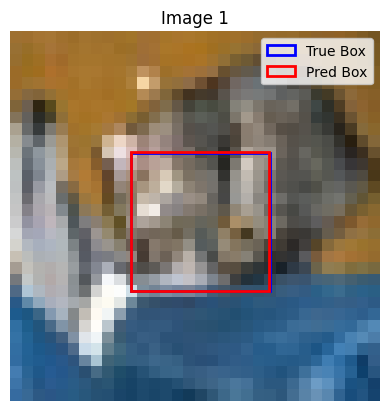

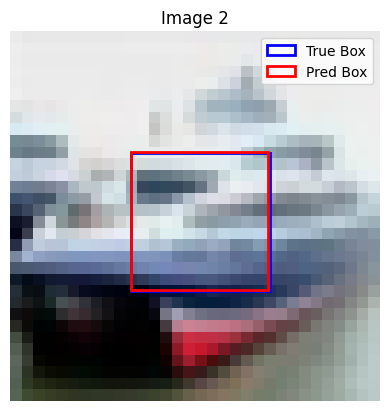

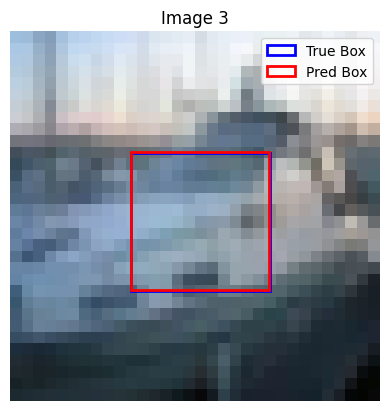

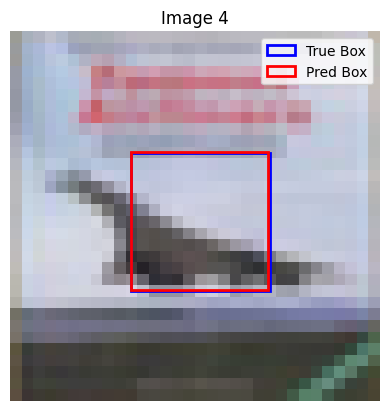

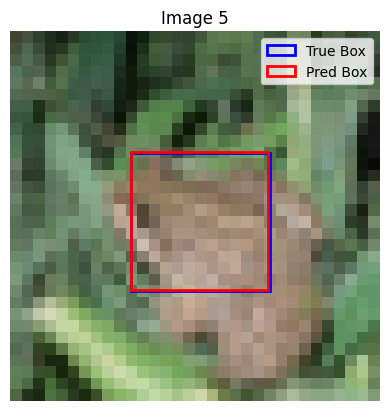

In [8]:
import matplotlib.pyplot as plt
# Make predictions
predictions = yolo_model.predict(x_test)

# Display predictions with corresponding images
def visualize_predictions(images, true_boxes, pred_boxes, num_images=5):
    for i in range(num_images):
        plt.imshow(images[i])

        # True boxes
        true_box = true_boxes[i]
        plt.gca().add_patch(plt.Rectangle((true_box[0], true_box[1]),
                                            true_box[2] - true_box[0],
                                            true_box[3] - true_box[1],
                                            edgecolor='blue', facecolor='none', linewidth=2, label='True Box'))

        # Predicted boxes
        pred_box = pred_boxes[i]
        plt.gca().add_patch(plt.Rectangle((pred_box[0], pred_box[1]),
                                            pred_box[2] - pred_box[0],
                                            pred_box[3] - pred_box[1],
                                            edgecolor='red', facecolor='none', linewidth=2, label='Pred Box'))

        plt.title(f'Image {i + 1}')
        plt.axis('off')
        plt.legend(loc='upper right')
        plt.show()

# Visualize predictions
visualize_predictions(x_test, dummy_boxes_test, predictions)


In [9]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    area_box1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area_box2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = area_box1 + area_box2 - intersection

    return intersection / union if union > 0 else 0

# Calculate IoU for predictions
for i in range(len(dummy_boxes_test)):
    iou = calculate_iou(predictions[i], dummy_boxes_test[i])
    print(f"Image {i + 1} - IoU: {iou:.2f}")


Streaming output truncated to the last 5000 lines.
Image 5001 - IoU: 0.94
Image 5002 - IoU: 0.96
Image 5003 - IoU: 0.97
Image 5004 - IoU: 0.96
Image 5005 - IoU: 0.97
Image 5006 - IoU: 0.98
Image 5007 - IoU: 0.93
Image 5008 - IoU: 0.95
Image 5009 - IoU: 0.94
Image 5010 - IoU: 0.96
Image 5011 - IoU: 0.95
Image 5012 - IoU: 0.98
Image 5013 - IoU: 0.97
Image 5014 - IoU: 0.96
Image 5015 - IoU: 0.98
Image 5016 - IoU: 0.94
Image 5017 - IoU: 0.95
Image 5018 - IoU: 0.96
Image 5019 - IoU: 0.96
Image 5020 - IoU: 0.97
Image 5021 - IoU: 0.98
Image 5022 - IoU: 0.92
Image 5023 - IoU: 0.97
Image 5024 - IoU: 0.96
Image 5025 - IoU: 0.97
Image 5026 - IoU: 0.94
Image 5027 - IoU: 0.96
Image 5028 - IoU: 0.95
Image 5029 - IoU: 0.96
Image 5030 - IoU: 0.96
Image 5031 - IoU: 0.96
Image 5032 - IoU: 0.96
Image 5033 - IoU: 0.94
Image 5034 - IoU: 0.95
Image 5035 - IoU: 0.94
Image 5036 - IoU: 0.96
Image 5037 - IoU: 0.96
Image 5038 - IoU: 0.96
Image 5039 - IoU: 0.94
Image 5040 - IoU: 0.97
Image 5041 - IoU: 0.97
Image 